# Hardware and Computational Capabilities

In [4]:
print()
print()

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mon Dec 26 17:57:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing the libraries

In [5]:
# install missing requirements in Colab
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#import skvideo.io as vidio
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py
#from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as tF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets, transforms, models
#from torchviz import make_dot
#from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

from sklearn.manifold import TSNE

#from torchvision.models.utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict 

import pickle
import tarfile
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=e7672f9bc26bc2cf0788fdc08c7495f5daaadec5f2c1d9f99f439f013a9d8d10
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


# Set the seed for reproducibility and create useful folders

In [6]:
def set_seed(seed = 16):
    np.random.seed(16)
    torch.manual_seed(16)

set_seed()

# create a folder called saved_models if it does not exist
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
    print('saved_models folder created')
else:
    print('saved_models folder already exists')

# create a folder called saved_plots if it does not exist
if not os.path.exists('saved_plots'):
    os.mkdir('saved_plots')
    print('saved_plots folder created')
else:
    print('saved_plots folder already exists')

saved_models folder created
saved_plots folder created


# Download SimCLR weights

To perform the downstream task we need weights from the training and implementation of SimCLR. 

You have two options:

1.   Perform your SimCLR training using Cifar100_SimCLR_Implementation.ipynb and save your training weights.
2.   Download the weights of the SimCLR training already done and peformated on 20 epochs.

Here you can find the pubblic link to download the weights:
https://drive.google.com/file/d/12PSiedTd-qIMcNB8mY-uaHiQhNR1oXQn/view?usp=share_link

# Load SimCLR model and update weights


In [ ]:
from models.resnet_simclr import PreModel

# define the device to use and print it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(str(device) + " will be used.")

# define the model and move it to the device
model = PreModel('resnet50','avgpool').to(device)

# load the weights
weights = torch.load('SimCLR_CIFAR100_RN50_END_TRAINING_Epoch_n20pt')
# weights = torch.load('saved_models/SimCLR_Ep20/SimCLR_CIFAR100_RN50_END_TRAINING_Epoch_n20pt')

# update model weights
model.load_state_dict(weights['model_state_dict'])

cuda:0 will be used.


<All keys matched successfully>

# Create Downstream model

In the code snippet below we create the model that will be used for the downstream task. We use the same architecture of the SimCLR model, but we change the output layer to have 100 outputs (one for each class of the Cifar100 dataset). Also, it can be seen that the projector is discarded in the downstream task here.


In [ ]:
# define the class for the downstream model
class DSModel(nn.Module):
    def __init__(self,premodel,num_classes):
        super().__init__()
        
        self.premodel = premodel
        
        self.num_classes = num_classes

        #TAKING OUTPUT FROM AN INTERMEDITATE LAYER
        #PREPRAING THE TRUNCATED MODEL
        
        for p in self.premodel.parameters():
            p.requires_grad = False
            
        for p in self.premodel.projector.parameters():
            p.requires_grad = False
        
        
        self.lastlayer = nn.Linear(2048,self.num_classes)
        
    def forward(self,x):
        out = self.premodel.pretrained(x)
        
        out = self.lastlayer(out)
        return out

# define the downstream model
dsmodel = DSModel(model, 100).to('cuda:0')

# Load Cifar100 dataset and prepare it

In [ ]:
from download_cifar100 import load_cifar100

# load cifar-10 data
images, labels, testimages, testlabels = load_cifar100()

# reshape training images and test images to 32x32x3
images = images.reshape((-1,3,32,32))
images = images.reshape((-1,3,32,32))
# change training images and test images type to float32
images = images.astype(np.float)
testimages = testimages.astype(np.float)
print('Training images and test images reshaped to 32x32x3 and changed to float32')
print('Training images shape: ' + str(images.shape) + ' | Test images shape: ' + str(testimages.shape))

# change training labels and test labels type to int64
labels = labels.astype(np.int)
testlabels = testlabels.astype(np.int)
print('Training labels and test labels changed to int64')

#calculate the channel-wise mean and standard deviation of the pixel values on the training split
MEAN = np.mean(images[:40000]/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(images[:40000]/255.0,axis=(0,2,3),keepdims=True)

#split 80:20 with batch5 as validation set
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]

Train data loaded!
Train data shape: (50000, 3072) | Train labels shape: (50000,)
Test data loaded!
Test data shape: (10000, 3072) | Test labels shape: (10000,)


<ipython-input-23-175232608b4a>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = images.astype(np.float)
<ipython-input-23-175232608b4a>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  testimages = testimages.astype(np.float)
<ipython-input-23-175232608b4a>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin

Training images and test images reshaped to 32x32x3 and changed to float32
Training images shape: (50000, 3, 32, 32) | Test images shape: (10000, 3072)
Training labels and test labels changed to int64


# DataGenerator for the Downstream task

In the downstream task, no augmentation except RandomResizedCrop has been used. The reason is that the SimCLR model has already performed the augmentation and the downstream task is just a classification task.

In [ ]:
# define datagenerator class for downstream task
class DSDataGen(Dataset):
    def __init__(self, phase, imgarr,labels,num_classes):
        
        self.phase = phase
        self.num_classes = num_classes
        self.imgarr = imgarr
        self.labels = labels
        
        self.indices = list(range(self.imgarr.shape[0]))
        
        self.randomcrop = transforms.RandomResizedCrop(32,(0.8,1.0))
    
    def __len__(self):
        return self.imgarr.shape[0]
    
    def __getitem__(self,idx):
        
        #DECLARE VARIABLES
        
        x = self.imgarr[idx]
        
        img = torch.from_numpy(x).float()
            
        #GET CLIP FRAMES
        #for i in range(4):
        label = self.labels[idx]

        #AUGMENT FRAMES
        if self.phase == 'train':
            img  = self.randomcrop(img)

        img = self.preprocess(img)
        
        return img, label
    
    def on_epoch_end(self):
        idx = random.sample(population = list(range(self.__len__())),k = self.__len__())
        self.imgarr = self.imgarr[idx]
        self.labels = self.labels[idx]
        
    def preprocess(self,frame):
        frame = frame / 255.0
        frame = (frame-MEAN)/STD
        
        return frame

# define number of frames
NUM_FRAMES = 16

# define number of classes of dataset
NUM_CLASSES = 100

# define downstream datagenerator for training data
dg = DSDataGen('train', trimages,trlabels, num_classes=NUM_CLASSES)

# define downstream dataloader for training data
dl = DataLoader(dg,batch_size = 32, drop_last = True)

# define datagenerator for validation data
vdg = DSDataGen('valid', valimages, vallabels,num_classes=NUM_CLASSES)

# define dataloader for validation data
vdl = DataLoader(vdg,batch_size = 32, drop_last = True)

# Define Optimizer, Loss and Scheduler

- Optimizer: SGD
- Loss: CrossEntropyLoss
- Scheduler: StepLR

In [ ]:
# OPTIMIZER
dsoptimizer = torch.optim.SGD([params for params in dsmodel.parameters() if params.requires_grad],lr = 0.01, momentum = 0.9)

# if you want to use Adam as optimizer, use the following code
#dsoptimizer = torch.optim.Adam([params for params in dsmodel.parameters() if params.requires_grad],lr=1e-5)

# SCHEDULER
lr_scheduler = torch.optim.lr_scheduler.StepLR(dsoptimizer, step_size=1, gamma=0.98, last_epoch=-1, verbose = True) #CosineAnnealingWarmRestarts(dsoptimizer,5,eta_min = 1e-6,last_epoch = -1, verbose = True) 

# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

Adjusting learning rate of group 0 to 1.0000e-02.


# Training loop for the Downstream task

In [ ]:
# define lists to store training losses, accuracies and auc scores
tr_ep_loss = []
tr_ep_acc = []
tr_ep_auc = []

# define lists to store validation losses, accuracies and auc scores
val_ep_loss = []
val_ep_acc = []
val_ep_auc = []

# define parameters for training
min_val_loss = 100.0
batch_size = 1
EPOCHS = 100
num_cl = 100
accumulation_steps = 1

In [ ]:
from utils import save_model

# define loop for training

for epoch in range(EPOCHS):
    
    stime = time.time()
    print("=============== Epoch : %3d ==============="%(epoch+1))
    
    loss_sublist = np.array([])
    acc_sublist = np.array([])
    
    #iter_num = 0
    dsmodel.train()
    
    dsoptimizer.zero_grad()
    
    for x,y in dl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = y.to(device = 'cuda:0')
        
        z = dsmodel(x)
        
        dsoptimizer.zero_grad()
        
        tr_loss = loss_fn(z,y) #/accumulation_steps #y.to(dtype=torch.float), z)
        tr_loss.backward()

        preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))
        
        #if (iter_num+1)%accumulation_steps==0:
        dsoptimizer.step()
        #dsoptimizer.zero_grad()
        
        loss_sublist = np.append(loss_sublist, tr_loss.cpu().data)
        acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)
        
        #iter_num+=1
    
    print('ESTIMATING TRAINING METRICS.............')
    
    print('TRAINING BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist)*accumulation_steps)
    print('TRAINING BINARY ACCURACY: ',np.mean(acc_sublist))
    #print('TRAINING AUC SCORE: ',roc_auc_score(gt,preds))
    
    tr_ep_loss.append(np.mean(loss_sublist))
    tr_ep_acc.append(np.mean(acc_sublist))
    
    #tr_ep_auc.append(roc_auc_score(gt, preds))
    
    
    
    print('ESTIMATING VALIDATION METRICS.............')
    
    dsmodel.eval()
    
    loss_sublist = np.array([])
    acc_sublist = np.array([])
    
    with torch.no_grad():
        for x,y in vdl:
            x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
            y = y.to(device = 'cuda:0')
            z = dsmodel(x)

            val_loss = loss_fn(z,y)

            preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

            loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
            acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)
            

    print('VALIDATION BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist))
    print('VALIDATION BINARY ACCURACY: ',np.mean(acc_sublist))
    #print('VALIDATION AUC SCORE: ',roc_auc_score(gt, preds))
    
    val_ep_loss.append(np.mean(loss_sublist))
    val_ep_acc.append(np.mean(acc_sublist))
    
    #val_ep_auc.append(roc_auc_score(gt, preds))
    
    lr_scheduler.step()
    
    dg.on_epoch_end()
    
    if np.mean(loss_sublist) <= min_val_loss:
        min_val_loss = np.mean(loss_sublist) 
        print('Saving model...')
        save_model(model, dsoptimizer , lr_scheduler, epoch, "Downstream_Linear_cifar100_END_TRAINING.pt")

        print('Saving loss and accuracy...')
        with open('saved_models/loss_Downstream_Linear_cifar100_END_TRAINING.pkl', 'wb') as f:
            pickle.dump([tr_ep_loss, tr_ep_acc, val_ep_loss, val_ep_acc], f)

        # torch.save({'model_state_dict': dsmodel.state_dict(),
        #         'optimizer_state_dict': dsoptimizer.state_dict()}, 
        #        '/saved_models/cifar10_rn50_p128_sgd0p01_decay0p98_all_lincls_300621.pt')
    
    print("Time Taken : %.2f minutes"%((time.time()-stime)/60.0))

=============== Epoch :   1 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOSS:  2.818901718235016
TRAINING BINARY ACCURACY:  0.31895
ESTIMATING VALIDATION METRICS.............
VALIDATION BINARY CROSSENTROPY LOSS:  2.437433788791681
VALIDATION BINARY ACCURACY:  0.3935296474358974
Adjusting learning rate of group 0 to 9.8000e-03.
Saving model...
Saving loss and accuracy...
Time Taken : 1.71 minutes
=============== Epoch :   2 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOSS:  2.5253366846084595
TRAINING BINARY ACCURACY:  0.37675
ESTIMATING VALIDATION METRICS.............
VALIDATION BINARY CROSSENTROPY LOSS:  2.344387552677057
VALIDATION BINARY ACCURACY:  0.4089543269230769
Adjusting learning rate of group 0 to 9.6040e-03.
Saving model...
Saving loss and accuracy...
Time Taken : 1.38 minutes
=============== Epoch :   3 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOS

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


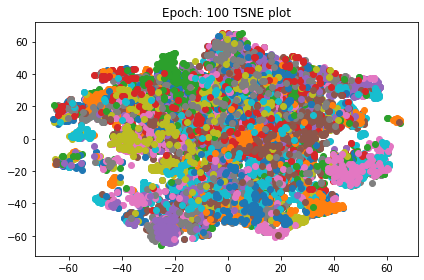

In [ ]:
from models.TSNE import plot_features

plot_features(dsmodel, 100, 100, 32, vdl, valimages, vallabels, EPOCHS)

# Plotting the results

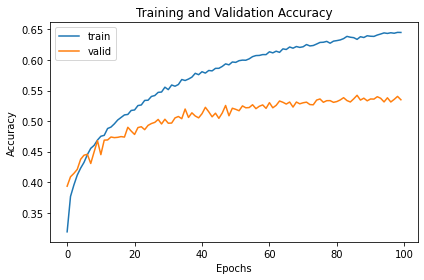

In [ ]:
# plot training and validation accuracy
plt.plot([t for t in tr_ep_acc])
plt.plot([t for t in val_ep_acc])
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','valid'])
plt.title('Training and Validation Accuracy')
plt.savefig('downstream_linear_acc.png', transparent=True)
plt.tight_layout()
plt.show()

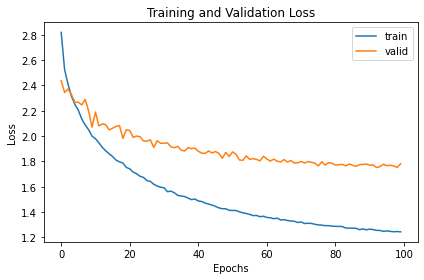

In [ ]:
# plot training and validation loss
plt.plot([t for t in tr_ep_loss])
plt.plot([t for t in val_ep_loss])
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','valid'])
plt.title('Training and Validation Loss')
plt.savefig('downstream_linear_loss.png', transparent=True)
plt.tight_layout()
plt.show()

# Testing the model: Downstream Inference

In [ ]:
# define data generator for test set
tdg = DSDataGen('test', testimages, testlabels, num_classes=100)
# define data loader for test set
tdl = DataLoader(tdg, batch_size = 32, drop_last = True)

# put model in evaluation mode
dsmodel.eval()

# define lists to store losses, accuracies and predictions obtained with argmax
loss_sublist = np.array([])
acc_sublist = np.array([])
predictions = np.array([])
gt = np.array([])

with torch.no_grad():
    for x,y in vdl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = y.to(device = 'cuda:0')
        z = dsmodel(x)

        val_loss = loss_fn(z,y)

        preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

        loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
        acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)
        predictions = np.append(predictions,np.argmax(preds,axis=1))
        gt = np.append(gt,y.cpu().data.view(-1))
                                                            
print('TEST BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist))
print('TEST BINARY ACCURACY: ',np.mean(acc_sublist))

TEST BINARY CROSSENTROPY LOSS:  1.7816955919067066
TEST BINARY ACCURACY:  0.5348557692307693


# Performance of the Downstream task

In [ ]:
# print precision
from sklearn.metrics import precision_score
ps = precision_score(gt, predictions, average='macro')
print('Precision: %.3f' % ps)

# print recall
from sklearn.metrics import recall_score
rs = recall_score(gt, predictions, average='macro')
print('Recall: %.3f' % rs)

# print f1-score
from sklearn.metrics import f1_score
f1 = f1_score(gt, predictions, average='macro')


# print precision, recall, f1-score and support
from sklearn.metrics import classification_report
cr = classification_report(gt, predictions)
print(cr)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(gt, predictions)
print(cm)

# plt.figure(figsize=(10,10))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.savefig('downstream_linear_confusion_matrix.png', transparent=True)
# plt.tight_layout()
# plt.show()

# save all results in a pickle file
import pickle
with open('saved_models/downstream_linear_results.pkl', 'wb') as f:
    pickle.dump([loss_sublist, acc_sublist, predictions, gt, ps, rs, f1, cr, cm], f)

Precision: 0.552
Recall: 0.534
              precision    recall  f1-score   support

         0.0       0.62      0.76      0.68       103
         1.0       0.52      0.54      0.53       113
         2.0       0.41      0.35      0.38        98
         3.0       0.45      0.19      0.27       101
         4.0       0.36      0.38      0.37       111
         5.0       0.58      0.74      0.65       109
         6.0       0.43      0.44      0.43        96
         7.0       0.55      0.37      0.44       107
         8.0       0.56      0.79      0.66        77
         9.0       0.96      0.66      0.78       102
        10.0       0.52      0.41      0.46       126
        11.0       0.33      0.33      0.33       102
        12.0       0.56      0.64      0.59       102
        13.0       0.75      0.56      0.64       107
        14.0       0.37      0.58      0.45        85
        15.0       0.38      0.64      0.48       107
        16.0       0.59      0.48      0.53       